In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
from functions import *
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

%matplotlib inline

In [5]:
data = pd.read_csv('./data/data.csv')

In [6]:
data=data.rename(columns = {"Unnamed: 0": "Date"})

In [7]:
data.tail()

Date          Load       CAPITL       CENTRL  \
146659  2017-04-24 19:00:00  16984.175000  1291.972222  1768.647222   
146660  2017-04-24 20:00:00  17615.657540  1341.735714  1843.365873   
146661  2017-04-24 21:00:00  17200.752778  1290.469444  1801.922222   
146662  2017-04-24 22:00:00  16148.388889  1193.955556  1687.572222   
146663  2017-04-24 23:00:00  14931.883333  1092.930556  1577.530556   

            DUNWOD       GENESE       HUD VL       LONGIL      MHK VL  \
146659  654.152778  1058.680556  1062.383333  2238.380556  855.547222   
146660  683.256349  1108.247222  1122.049603  2388.324206  884.457540   
146661  675.925000  1091.652778  1086.563889  2318.411111  846.966667   
146662  641.322222  1011.200000  1007.902778  2140.886111  776.563889   
146663  583.055556   933.863889   920.994444  1937.283333  699.247222   

            MILLWD       N.Y.C.       NORTH         WEST  N.Y.C._LONGIL  
146659  289.441667  5559.388889  487.286111  1718.294444            NaN  
146660  311.366270  5647.025397  498.217460  1787.611905            NaN  
146661  290.966667  5521.511111  492.600000  1783.763889            NaN  
146662  258.008333  5256.850000  475.905556  1698.222222            NaN  
146663  231.258333  4895.633333  460.969444  1599.116667            NaN

In [8]:
data.Date = pd.to_datetime(data.Date)

In [9]:
data.set_index('Date', inplace = True)

In [10]:
data.sort_index(inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


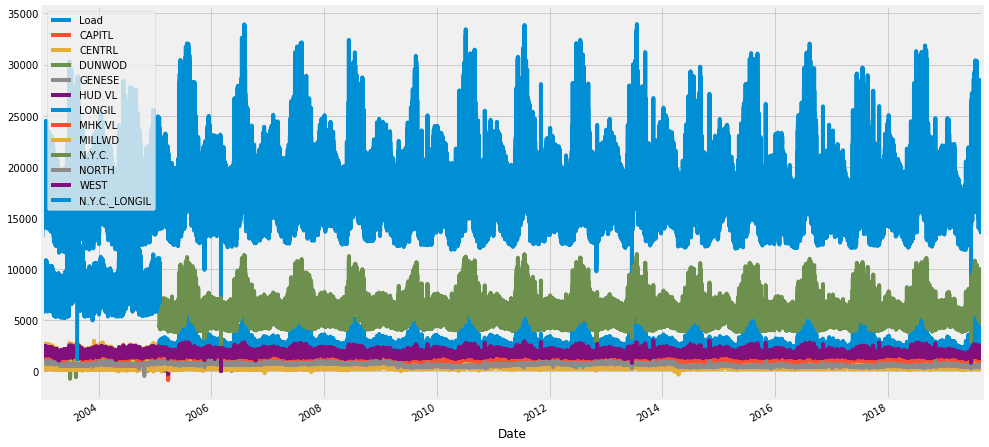

In [12]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [13]:
data.isna().sum()

Load                630
CAPITL              630
CENTRL              630
DUNWOD              630
GENESE              630
HUD VL              630
LONGIL            18855
MHK VL              630
MILLWD              630
N.Y.C.            18855
NORTH               630
WEST                630
N.Y.C._LONGIL    128439
dtype: int64

In [14]:
#drop NaNs
target = 'Load'
_id='date'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [15]:
data.shape

(146034, 13)

In [16]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]

In [17]:
data.drop(drop_cols, axis=1, inplace=True)

In [18]:
data.head()

Load
Date                             
2003-01-01 00:00:00  15415.625000
2003-01-01 01:00:00  14569.928571
2003-01-01 02:00:00  13812.200000
2003-01-01 03:00:00  13315.333333
2003-01-01 04:00:00  13156.333333

In [19]:
data = create_features(data, target)

In [20]:
data.dropna(inplace=True)

In [21]:
reg = xgb.XGBRegressor()

In [22]:
splits = create_split(data, 10)
smapes=[]
smapes_daily=[]
smape_list = []
smape_list_daily = []
for start, end in splits:
    sample = data[start:end]
    split_at = int(len(sample) * 0.8)
    train, keep_cols, used_cols = data_prep(sample[:split_at], target, _id)
    X_train = train[used_cols].iloc[:-(24),:]
    y_train = train[target].shift(-(24)).dropna()
    test, keep_cols, used_cols = data_prep(sample[split_at:], target, _id)
    X_test = test[used_cols].iloc[:-(24),:]
    y_test = test[target].shift(-(24)).dropna()
    reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train)],
        eval_metric = 'mae',
        early_stopping_rounds=25, 
        verbose=False)
    y_pred = reg.predict(X_test)
    s = symmetric_mape(y_test, y_pred)
    s_1 = symmetric_mape(y_test[:24], y_pred[:24])
    smape_list.append(s)
    smape_list_daily.append(s_1)
    avg = sum(smape_list)/len(smape_list)
    avg_daily=sum(smape_list_daily)/len(smape_list_daily)
    smapes.append(avg)
    print("SMAPE per fold: ", s, "\n")
    print("SMAPE first day per fold: ",s_1,"\n")
    print("First Day Average : ", avg_daily)
    print("Average : ", avg)
    print("\n")
    

[00:11:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE per fold:  8.145284409101576 

SMAPE first day per fold:  4.537650638810371 

First Day Average :  4.537650638810371
Average :  8.145284409101576


[00:11:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE per fold:  4.278407945080446 

SMAPE first day per fold:  5.166146829616068 

First Day Average :  4.851898734213219
Average :  6.211846177091012


[00:11:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE per fold:  3.5806632649610544 

SMAPE first day per fold:  5.721565432086521 

First Day Average :  5.14178763350432
Average :  5.334785206381025


[00:11:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SMAPE per fold:  3.5836932492758637 

SMAPE first day per fold:  1.4902623

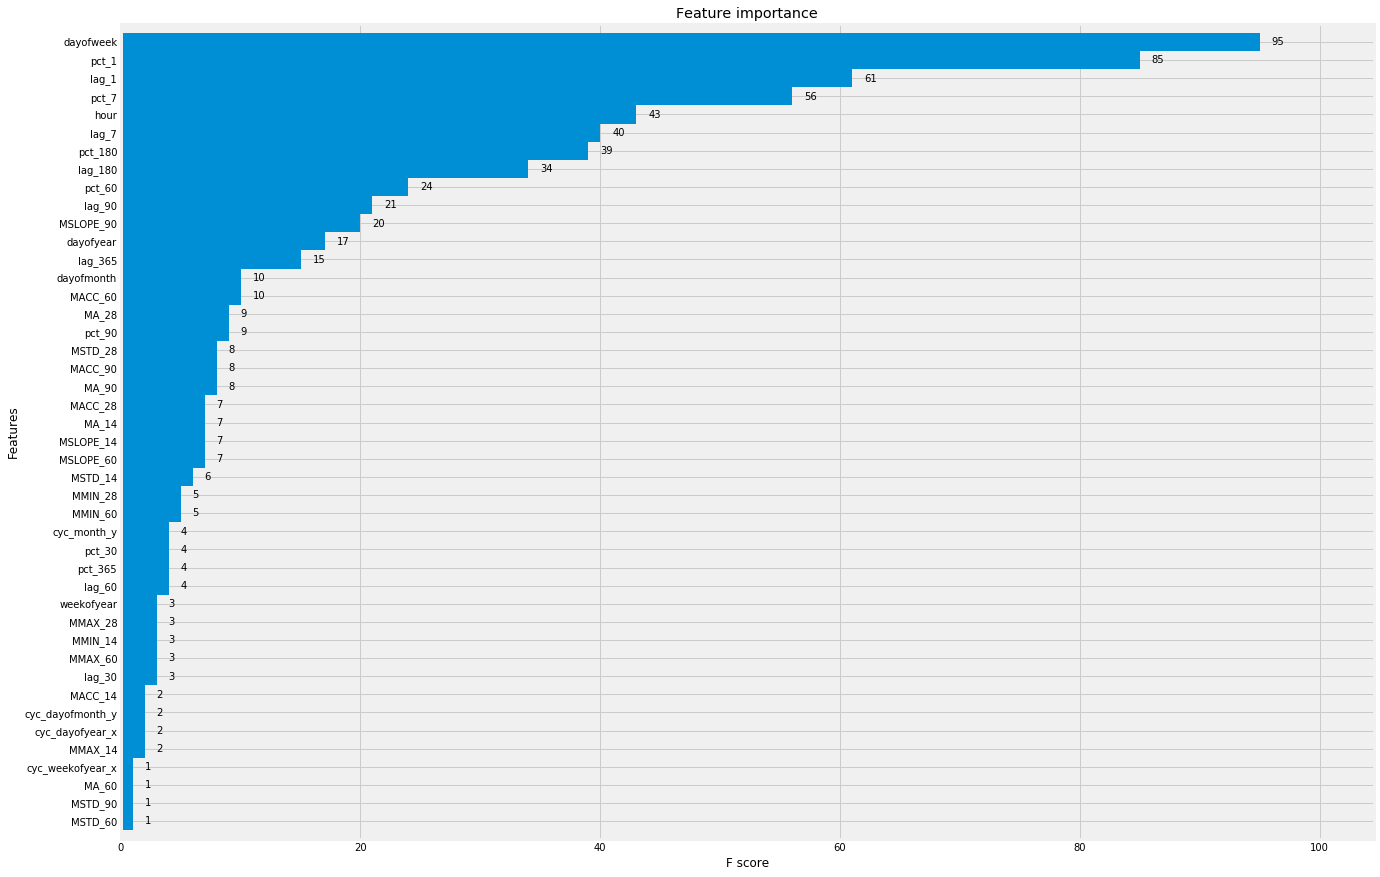

In [23]:
plt.rcParams["figure.figsize"] = (20, 15)
xgb.plot_importance(reg, height = 1)

In [24]:
MSE = mean_squared_error(y_test, y_pred)
print(MSE)

1343721.7841371028


In [25]:
MAE = mean_absolute_error(y_test, y_pred)
print(MAE)

843.597905856488


In [26]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(MAPE)

4.517521687873429


In [27]:
sMAPE = symmetric_mape(y_test, y_pred)
print(sMAPE)

4.494009872108042


In [28]:
sMAPE = symmetric_mape(y_test[:(24)], y_pred[:(24)])
print(sMAPE)

4.453480830964343


In [29]:
RMSE = np.sqrt(MSE)
print(RMSE)

1159.1901414940962


In [30]:
FE = forecast_error(y_test, y_pred)
MFE = mean_forecast_error(FE)
print(MFE)

-32.06217388030258


In [31]:
r_squared = r2_score(y_test, y_pred)
print(r_squared)

0.8877736140402827


In [32]:
X_test.head(10)

hour  dayofweek  quarter  month  year  dayofyear  \
Date                                                                    
2016-07-13 22:00:00    22          2        3      7  2016        195   
2016-07-13 23:00:00    23          2        3      7  2016        195   
2016-07-14 00:00:00     0          3        3      7  2016        196   
2016-07-14 01:00:00     1          3        3      7  2016        196   
2016-07-14 02:00:00     2          3        3      7  2016        196   
2016-07-14 03:00:00     3          3        3      7  2016        196   
2016-07-14 04:00:00     4          3        3      7  2016        196   
2016-07-14 05:00:00     5          3        3      7  2016        196   
2016-07-14 06:00:00     6          3        3      7  2016        196   
2016-07-14 07:00:00     7          3        3      7  2016        196   

                     dayofmonth  weekofyear         MA_14       MMAX_14  ...  \
Date                                                                     ...   
2016-07-13 22:00:00          13          28  20620.609314  29670.008333  ...   
2016-07-13 23:00:00          13          28  20628.931934  29670.008333  ...   
2016-07-14 00:00:00          14          28  20637.472831  29670.008333  ...   
2016-07-14 01:00:00          14          28  20646.080569  29670.008333  ...   
2016-07-14 02:00:00          14          28  20654.687340  29670.008333  ...   
2016-07-14 03:00:00          14          28  20663.430817  29670.008333  ...   
2016-07-14 04:00:00          14          28  20672.501750  29670.008333  ...   
2016-07-14 05:00:00          14          28  20682.480371  29670.008333  ...   
2016-07-14 06:00:00          14          28  20692.977420  29670.008333  ...   
2016-07-14 07:00:00          14          28  20704.156462  29670.008333  ...   

                          lag_365   pct_365  cyc_month_x   cyc_month_y  \
Date                                                                     
2016-07-13 22:00:00  23895.191667  1.018012          1.0 -4.898587e-16   
2016-07-13 23:00:00  22618.008333  1.041744          1.0 -4.898587e-16   
2016-07-14 00:00:00  20879.250000  1.032993          1.0 -4.898587e-16   
2016-07-14 01:00:00  19396.883333  1.006888          1.0 -4.898587e-16   
2016-07-14 02:00:00  18349.983333  0.988180          1.0 -4.898587e-16   
2016-07-14 03:00:00  17629.933333  0.967496          1.0 -4.898587e-16   
2016-07-14 04:00:00  17184.558333  0.942461          1.0 -4.898587e-16   
2016-07-14 05:00:00  17087.666667  0.905936          1.0 -4.898587e-16   
2016-07-14 06:00:00  17583.508333  0.869885          1.0 -4.898587e-16   
2016-07-14 07:00:00  18879.564286  0.851102          1.0 -4.898587e-16   

                     cyc_dayofmonth_x  cyc_dayofmonth_y  cyc_dayofyear_x  \
Date                                                                       
2016-07-13 22:00:00          0.885456      4.647232e-01         0.899968   
2016-07-13 23:00:00          0.885456      4.647232e-01         0.899968   
2016-07-14 00:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 01:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 02:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 03:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 04:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 05:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 06:00:00          1.000000     -2.449294e-16         0.900969   
2016-07-14 07:00:00          1.000000     -2.449294e-16         0.900969   

                     cyc_dayofyear_y  cyc_weekofyear_x  cyc_weekofyear_y  
Date                                                                      
2016-07-13 22:00:00         0.435956              -1.0      1.224647e-16  
2016-07-13 23:00:00         0.435956              -1.0      1.224647e-16  
2016-07-14 00:00:00         0.433884              -1.0      1.224647e-16  
2016-0

In [33]:
X_train.head()

hour  dayofweek  quarter  month  year  dayofyear  \
Date                                                                    
2004-01-02 12:00:00    12          4        1      1  2004          2   
2004-01-02 13:00:00    13          4        1      1  2004          2   
2004-01-02 14:00:00    14          4        1      1  2004          2   
2004-01-02 15:00:00    15          4        1      1  2004          2   
2004-01-02 16:00:00    16          4        1      1  2004          2   

                     dayofmonth  weekofyear         MA_14       MMAX_14  ...  \
Date                                                                     ...   
2004-01-02 12:00:00           2           1  17193.743225  22440.071429  ...   
2004-01-02 13:00:00           2           1  17190.266836  22440.071429  ...   
2004-01-02 14:00:00           2           1  17186.624773  22440.071429  ...   
2004-01-02 15:00:00           2           1  17182.505155  22440.071429  ...   
2004-01-02 16:00:00           2           1  17177.015795  22440.071429  ...   

                          lag_365   pct_365  cyc_month_x   cyc_month_y  \
Date                                                                     
2004-01-02 12:00:00  15415.625000  0.813243          1.0 -4.898587e-16   
2004-01-02 13:00:00  14569.928571  0.776420          1.0 -4.898587e-16   
2004-01-02 14:00:00  13812.200000  0.743636          1.0 -4.898587e-16   
2004-01-02 15:00:00  13315.333333  0.717346          1.0 -4.898587e-16   
2004-01-02 16:00:00  13156.333333  0.682110          1.0 -4.898587e-16   

                     cyc_dayofmonth_x  cyc_dayofmonth_y  cyc_dayofyear_x  \
Date                                                                       
2004-01-02 12:00:00               1.0     -2.449294e-16              1.0   
2004-01-02 13:00:00               1.0     -2.449294e-16              1.0   
2004-01-02 14:00:00               1.0     -2.449294e-16              1.0   
2004-01-02 15:00:00               1.0     -2.449294e-16              1.0   
2004-01-02 16:00:00               1.0     -2.449294e-16              1.0   

                     cyc_dayofyear_y  cyc_weekofyear_x  cyc_weekofyear_y  
Date                                                                      
2004-01-02 12:00:00    -2.449294e-16               1.0     -4.898587e-16  
2004-01-02 13:00:00    -2.449294e-16               1.0     -4.898587e-16  
2004-01-02 14:00:00    -2.449294e-16               1.0     -4.898587e-16  
2004-01-02 15:00:00    -2.449294e-16               1.0     -4.898587e-16  
2004-01-02 16:00:00    -2.449294e-16               1.0     -4.898587e-16  

[5 rows x 54 columns]

In [34]:
X_train.shape

(109795, 54)

In [35]:
y_train.shape

(109795,)

In [36]:
X_test.shape

(27431, 54)

In [37]:
y_test.shape

(27431,)

In [38]:
y_pred.shape

(27431,)

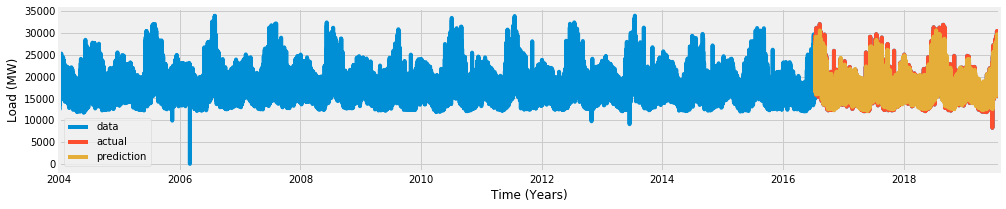

In [39]:
plt.figure(figsize=(15,3))
plt.xlabel('Time (Years)')
plt.ylabel('Load (MW)')
# plt.title("")
plt.plot(data.iloc[:-(24),:].index, data[target].shift(-(24)).dropna(), '-', label='data')
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='01-02-2004', right='07-31-2019')
plt.show()

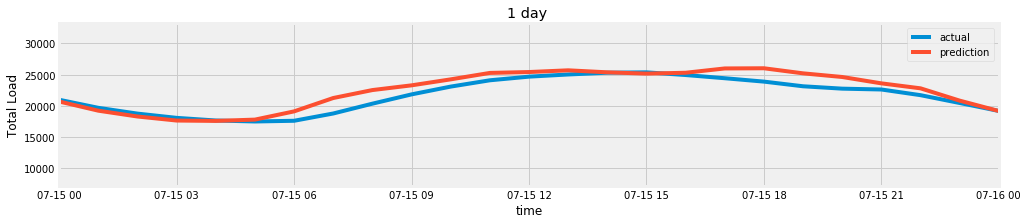

In [40]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 day ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-16-2016')
plt.show()
# plot_(X_test, y_test, '06-23-2019', y_test.index[48], "1 day ")

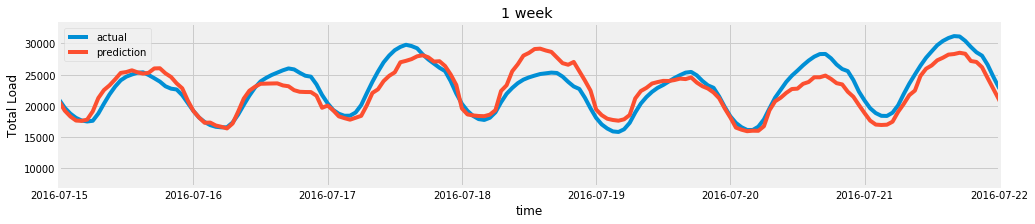

In [41]:
plt.figure(figsize=(15,3))
plt.xlabel('time')
plt.ylabel('Total Load')
plt.title("1 week ")
plt.plot(X_test.index, y_test, '-', label='actual')
plt.plot(X_test.index, y_pred, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-22-2016')
plt.show()

In [42]:
day_fcst = y_pred[:50]
act_ = y_test[:50]
act_2 = y_test[:26]

In [43]:
dm = X_test.copy()

In [44]:
dm=dm.reset_index()

In [45]:
x_vals = dm['Date'].shift(-24).dropna()

In [46]:
x_ = x_vals[:50]

In [47]:
x_2 = x_vals[:26]

In [48]:
len(y_test[:55])

55

In [49]:
len(act_)

50

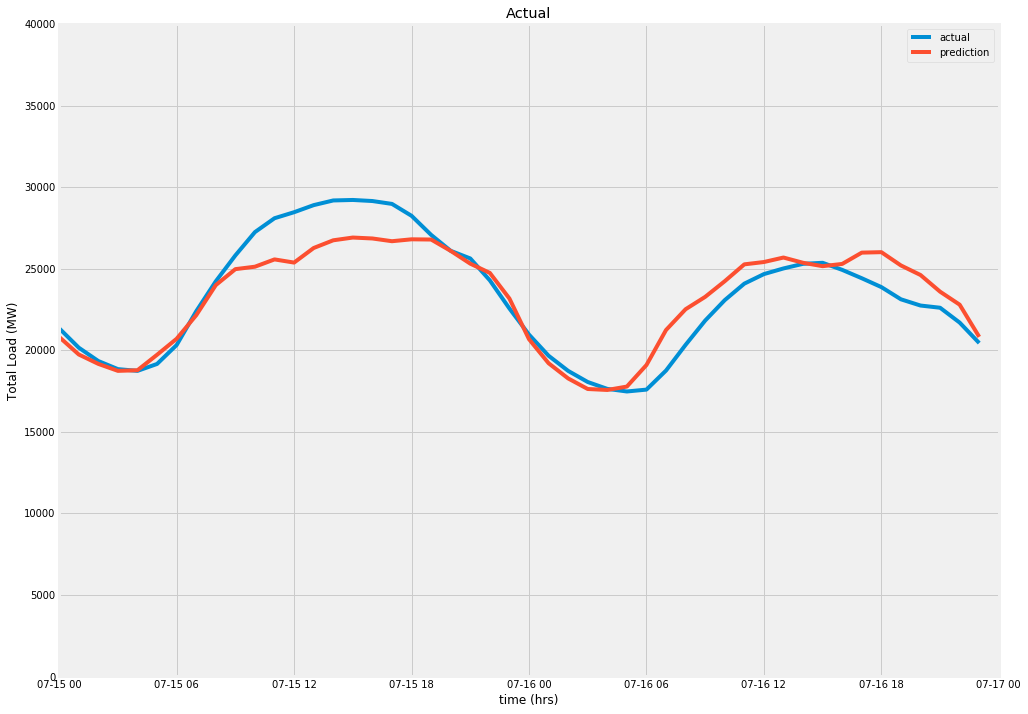

In [50]:
plt.figure(figsize=(15,12))
plt.xlabel('time (hrs)')
plt.ylabel('Total Load (MW)')
plt.title("Actual")
plt.plot(x_, act_, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-17-2016')
plt.ylim(0,40000)
plt.show()

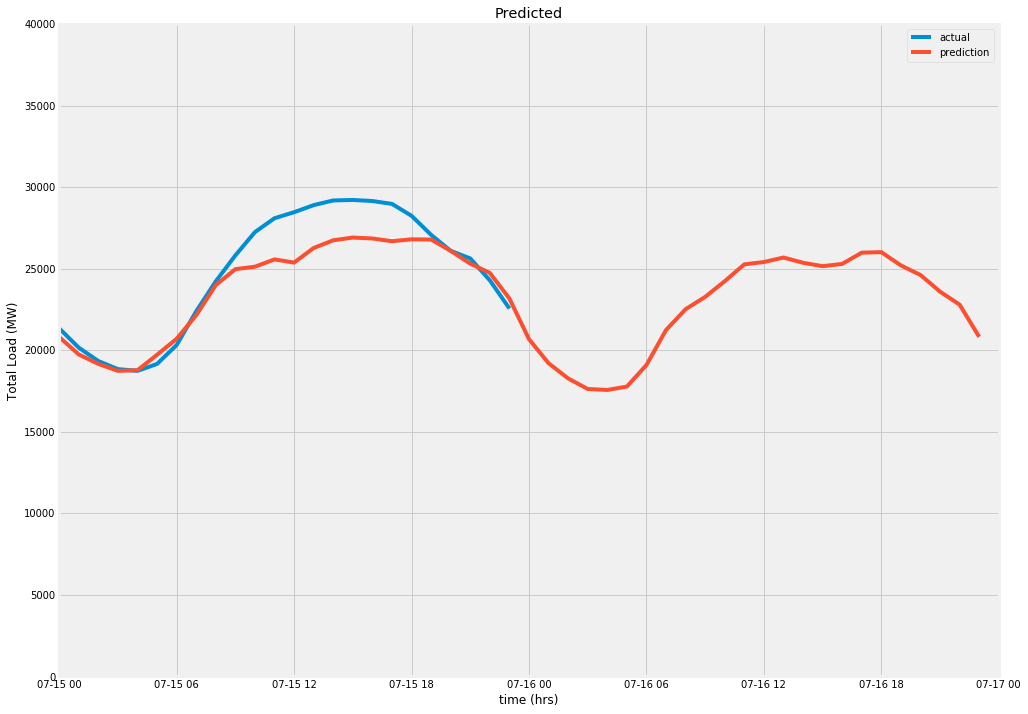

In [51]:
plt.figure(figsize=(15,12))
plt.xlabel('time (hrs)')
plt.ylabel('Total Load (MW)')
plt.title("Predicted")
plt.plot(x_2, act_2, '-', label='actual')
plt.plot(x_, day_fcst, '-', label='prediction')
plt.legend()
plt.xlim(left='07-15-2016', right='07-17-2016')
plt.ylim(0,40000)
plt.show()

In [52]:
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")

fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, name="Test",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, name="Predicted",
                         line_color='dimgray'))

fig.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)
fig.show()